# Scratch

In [39]:
for job in project.find_jobs({'local_stability': 'stable', 'module': 'chain'}):
    print(job.doc['omega_unconstrained'])
    break

{'01': 0.0, '01,02': 0.0, '01,02,10': 0.3981818181818182, '01,02,10,12': 0.46789473684210525, '01,02,10,12,20': 0.6937142857142857, '01,02,10,12,20,21': 0.8217910447761194, '01,02,10,12,21': 0.722, '01,02,10,20': 0.5368421052631579, '01,02,10,20,21': 0.7025714285714286, '01,02,10,21': 0.6957894736842105, '01,02,12': 0.017272727272727273, '01,02,12,20': 0.8115789473684211, '01,02,12,20,21': 0.8765714285714286, '01,02,12,21': 0.4110526315789474, '01,02,20': 0.4072727272727273, '01,02,20,21': 0.4573684210526316, '01,02,21': 0.08727272727272728, '01,10': 0.40285714285714286, '01,10,12': 0.48545454545454547, '01,10,12,20': 0.6894736842105263, '01,10,12,20,21': 0.7754285714285715, '01,10,12,21': 0.6036842105263158, '01,10,20': 0.4772727272727273, '01,10,20,21': 0.4942105263157895, '01,10,21': 0.4681818181818182, '01,12': 0.01, '01,12,20': 0.8245454545454546, '01,12,20,21': 0.8594736842105263, '01,12,21': 0.39636363636363636, '01,20': 0.09142857142857143, '01,20,21': 0.21181818181818182, '01,

#### histogram interaction model parameter values

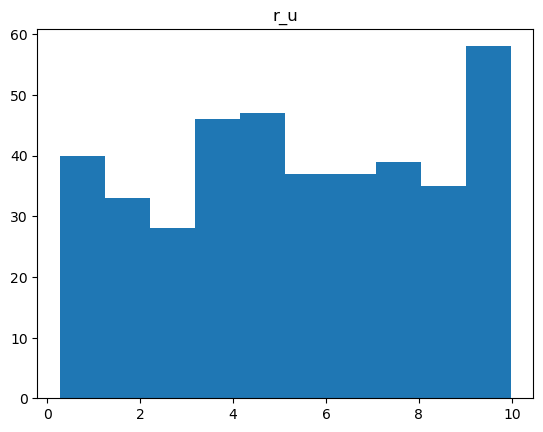

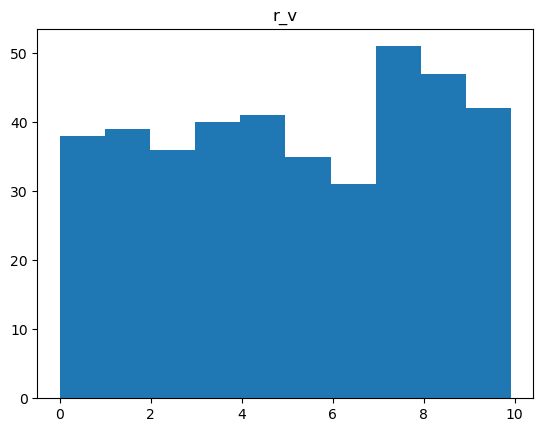

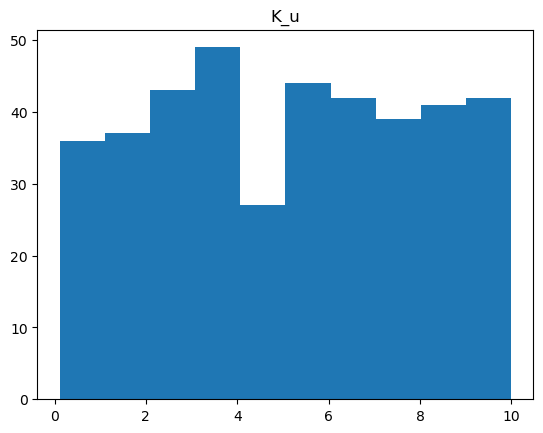

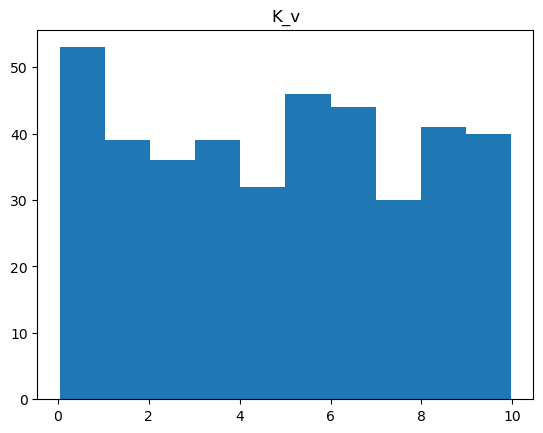

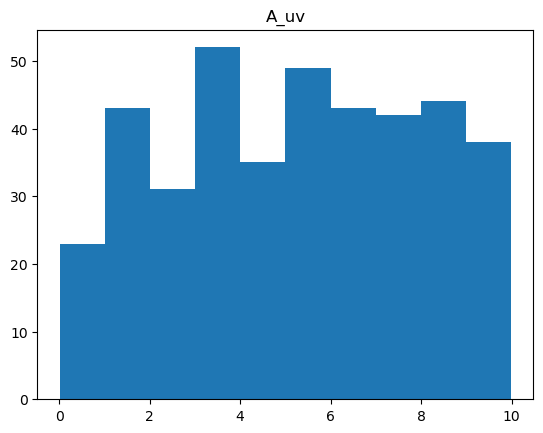

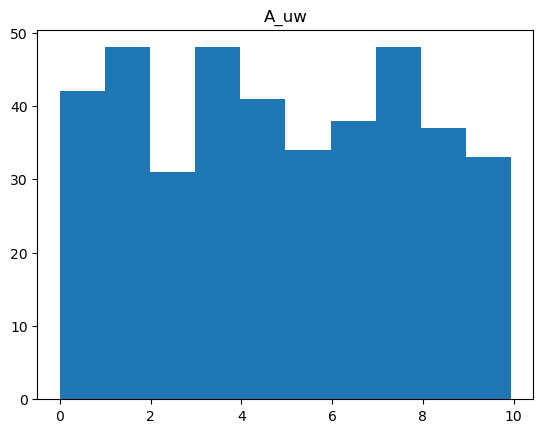

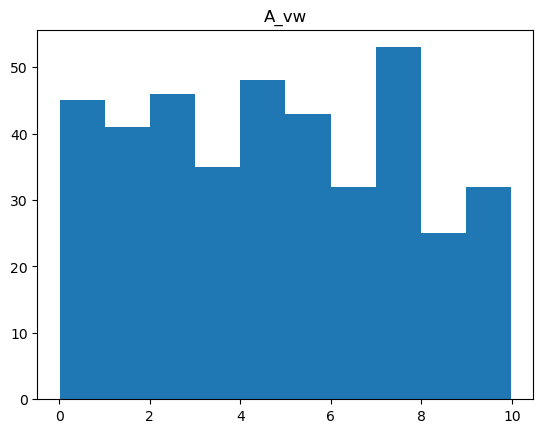

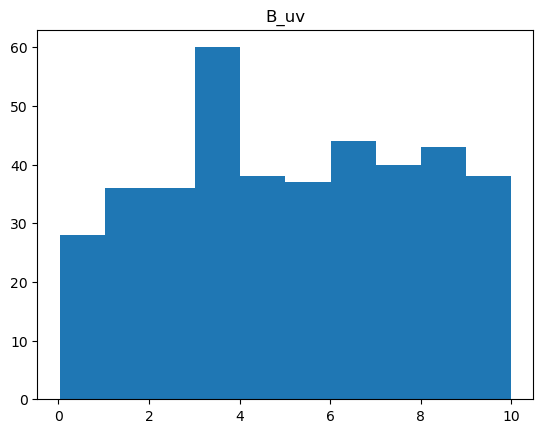

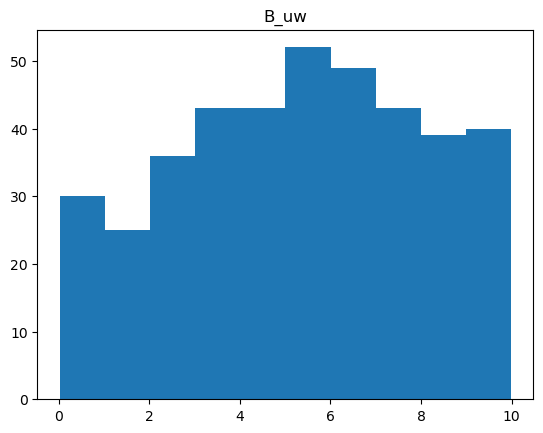

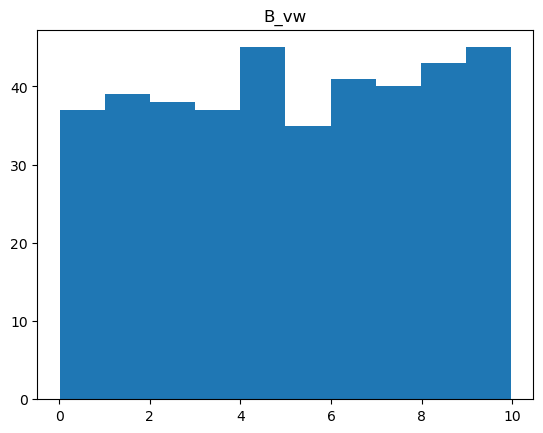

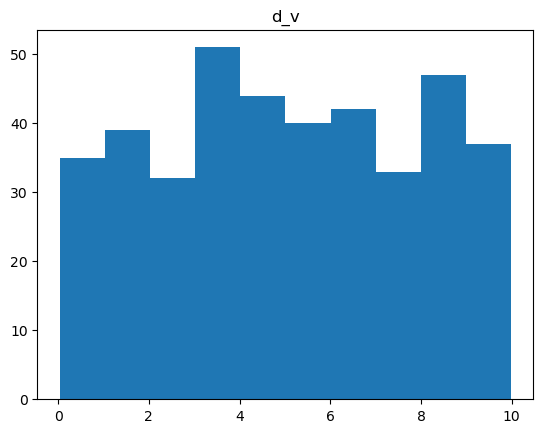

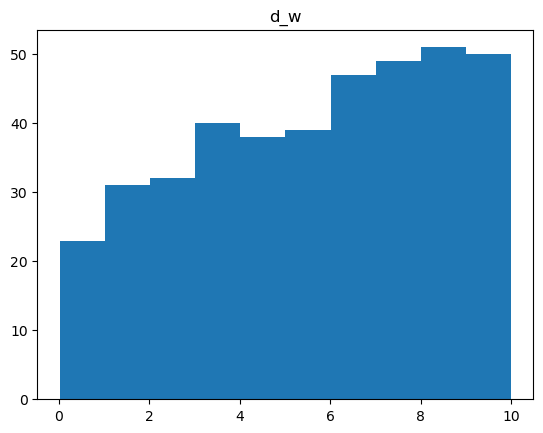

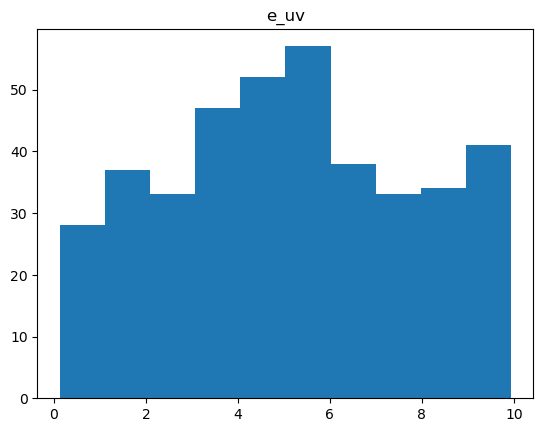

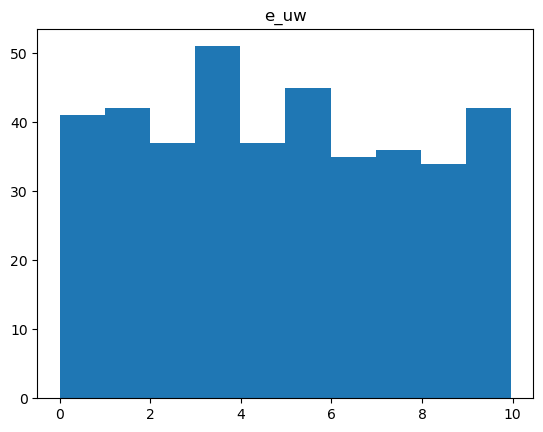

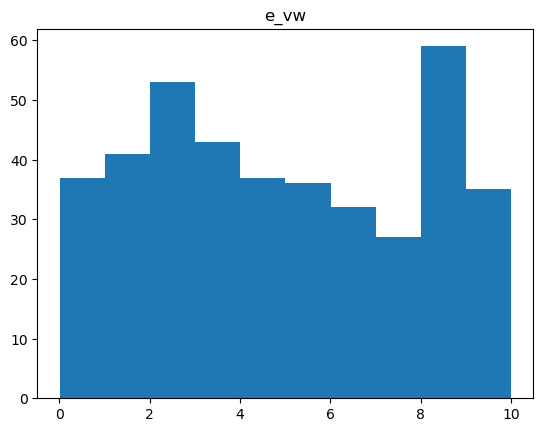

In [118]:
model_params = ['r_u', 'r_v', 'K_u', 'K_v', 'A_uv', 'A_uw', 'A_vw', 'B_uv', 'B_uw', 'B_vw', 'd_v', 'd_w', 'e_uv', 'e_uw', 'e_vw']
for p in model_params:
    p_vals = np.array(list(project.detect_schema()['model_params.'+p][float]))
    plt.hist(p_vals)
    plt.title(p)
    plt.show()

#### histogram Jacobian elements for each module

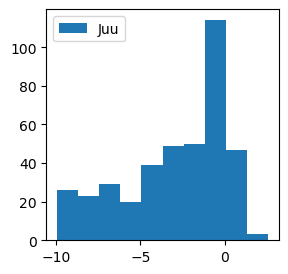

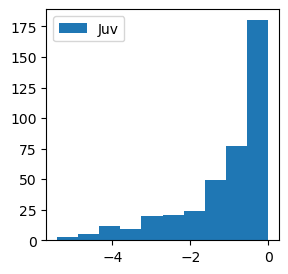

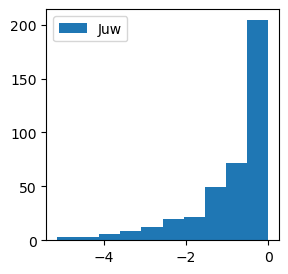

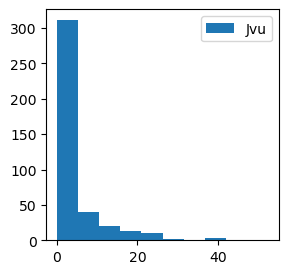

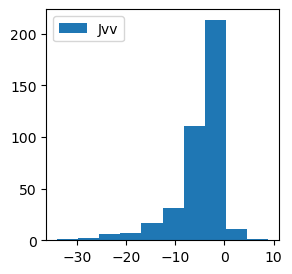

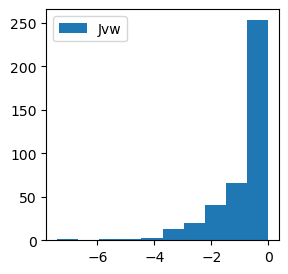

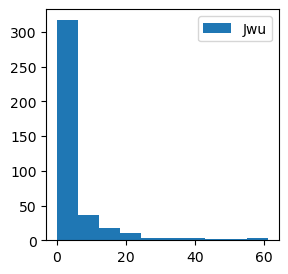

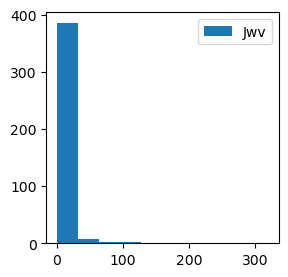

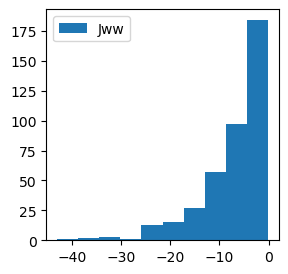

In [119]:
labels = ['Juu', 'Juv', 'Juw', 
          'Jvu', 'Jvv', 'Jvw',
          'Jwu', 'Jwv', 'Jww']
# for module in modules:
#     print(module,'---------------------------------------------')
#     all_Js = []
#     for job in project.find_jobs({'doc.surface_generated': True, 'module': module}):
#         with job.data as data:
#             J = np.array(data['J'])
#             all_Js.append(J.flatten())
#     all_Js = np.array(all_Js)
#     for i in range(9):
#         plt.figure(figsize=(3,3))
#         plt.hist(all_Js[:,i], label=labels[i])
#         plt.legend()
#         plt.show()

all_Js = []
for job in project.find_jobs({'doc.surface_generated': True}):
    with job.data as data:
        J = np.array(data['J'])
        all_Js.append(J.flatten())
all_Js = np.array(all_Js)
for i in range(9):
    plt.figure(figsize=(3,3))
    plt.hist(all_Js[:,i], label=labels[i])
    plt.legend()
    plt.show()

# Prep

## Imports and initializations

In [1]:
import numpy as np
import signac as sg
import pickle
from itertools import product, combinations, accumulate, groupby
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from project import spherical_to_cartesian
import sys

In [2]:
project = sg.get_project()

# Read in shared data
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    adj_mats = np.array(sd['adj_mats'])
    modules = np.array([i.decode() for i in sd['modules']])
    cross_labels = np.array([i.decode() for i in sd['cross_labels']])
    C_offdiags = np.array(sd['C_offdiags'])

diagrams = ['w\n|\nv\n|\nu', 'w   v\n \ /\n  u', '  w\n / \\\nu   v', '  w\n / \\\nu - v']
spec_labels = ['u', 'v', 'w']
C_offdiags_labels = [r'$C_{{{}{}}}$'.format(spec_labels[C_ij[0][0]], spec_labels[C_ij[0][1]]) for C_ij in C_offdiags]
n_cross_arr = np.arange(0, len(C_offdiags)+1)
# Define q values which yield mean (expected) values for each possible number of nonzero cross diffusive elements
q_expected_arr = np.linspace(0, 1, len(C_offdiags)+1)

# Many parameterizations

In [3]:
df = project.to_dataframe(sp_prefix='', doc_prefix='', flatten=True)
model_params = [p for p in list(project.detect_schema()) if 'model_params' in p]
cross_colors = ['mediumblue', 'cornflowerblue', 'green', 'yellowgreen', 'orangered', 'lightcoral']
# Get column labels for data with n_cross nonzero offdiagonal C elements
cross_labels = []
for n_cross in n_cross_arr:
    if n_cross == 0:
        labels = ['diag']
    else:
        cross_combs = [comb for comb in combinations(C_offdiags, n_cross)]
        labels = []
        for cross_comb in cross_combs:
            '''Do I need to fix this in project.py?'''
            cross_comb = np.array((cross_comb))[:,0]
            cross_label = ','.join([str(c[0])+str(c[1]) for c in cross_comb])
            labels.append(cross_label)
    cross_labels.append(labels)

## Recreate random matrix plot

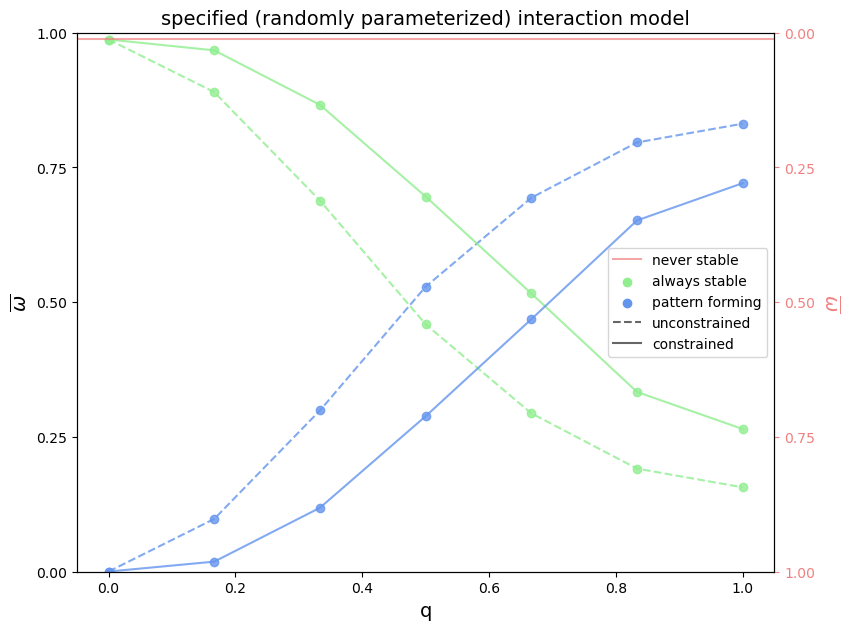

In [13]:
savefig = True
per_module = False
verbose = False
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'average_omega_per_module.png' if per_module else 'average_omega.png'
colors = ('lightgreen', 'cornflowerblue', 'lightcoral')
alp = 0.8
constraint_keys = ['unconstrained', 'constrained']
stab_keys = ['ddi', 'stab']

# Initialize plotting
if per_module:
    num_subplots = len(modules)
    plt.figure(figsize=(10.5*num_subplots, 7))
else:
    plt.figure(figsize=(9,7))
    ax = plt.subplot()
    num_subplots = 1

for i in range(num_subplots):
    # Initialize data
    data = {}
    for key in stab_keys:
        data[key] = {c: np.zeros(len(q_expected_arr)) for c in constraint_keys}
    # Filter for feasible parameterizations in desired module(s)
    if per_module:
        ax = plt.subplot(1, num_subplots, i+1)
        df_module = df[(df['local_stability'] != 'infeasible') & (df['module'] == modules[i])]
    else:
        df_module = df[df['local_stability'] != 'infeasible']
    # Store fraction of never stable (only depends on parameterizations)
    ns_bool = df_module['local_stability'] == 'unstable'
    ns_mean = sum(ns_bool) / len(df_module)
    data['ns'] = ns_mean
    
    # Get omega, constrained and unconstrained, at each value of q
    for q, n_cross in zip(q_expected_arr, n_cross_arr):
        n_cross_i = np.nonzero(n_cross_arr == n_cross)[0][0]
        if verbose: print('q',q, n_cross)
        if verbose: print('cross scenarios', cross_labels[n_cross_i])
        if verbose: print('never stable', data['ns'])
        for c_key, s_key in product(constraint_keys, stab_keys):
            if verbose: print(c_key, s_key)
            # Get the mean for each cross diffusive scenario with off diagonal probability q
            means = []
            for cross_label in cross_labels[n_cross_i]:
                if verbose: print('scenario:', cross_label)
                # Get the column label for this scenario in data
                data_label = 'omega_{}.{}'.format(c_key, cross_label)
                # Get the mean value of omega (ddi and stable) across parameterizations
                if s_key == 'ddi':
                    mean = np.nanmean(df_module[data_label])
                    if verbose: print('omega ddi per parameterization', np.array(df_module[data_label]))
                    # means.append(df_module[data_label].mean(skipna=True))
                    means.append(mean)
                    if verbose: print('mean across parameterizations', mean)
                elif s_key == 'stab':
                    # If invalid cross scenario (np.nan stored), set omega_stable to nan too
                    if np.all(np.isnan(df_module[data_label])):
                        mean = np.nan
                        if verbose: print('omega stab per parameterization', mean)
                    else:
                        stab_arr = 1.0 - np.array(df_module[data_label])
                        stab_arr = np.where(ns_bool, 0.0, stab_arr)
                        if verbose: print('omega stab per parameterization', stab_arr)
                        mean = np.nanmean(stab_arr)
                    means.append(mean)
                    if verbose: print('mean across parameterizations', mean)
                else:
                    sys.exit('Invalid stability key')
            if verbose: print('mean for each scenario', means)
            if verbose: print('mean across scenarios', np.nanmean(means))
            if verbose: print('---------------------------------')
            # Store the mean over all scenarios
            data[s_key][c_key][n_cross_i] = np.nanmean(means)
        if verbose: print()
        
    # Plot
    for constraint_key in constraint_keys:
        ls = '--' if constraint_key == 'unconstrained' else '-'
        ax.plot(q_expected_arr, data['stab'][constraint_key], ls=ls, c=colors[0], alpha=alp)
        ax.scatter(q_expected_arr, data['stab'][constraint_key], c=colors[0], alpha=alp)
        ax.plot(q_expected_arr, data['ddi'][constraint_key], ls=ls, c=colors[1], alpha=alp)
        ax.scatter(q_expected_arr, data['ddi'][constraint_key], c=colors[1], alpha=alp)
    # Dummy horizontal line for never stable label, actually plot on 2nd y axis
    ax.axhline(-1, ls='-', color=colors[2], label='never stable', alpha=alp-0.1)
    ax.scatter([], [], c=colors[0], label='always stable')
    ax.scatter([], [], c=colors[1], label='pattern forming')
    ax.plot([], [], ls='--', alpha=0.6, color='black', label='unconstrained')
    ax.plot([], [], alpha=0.6, color='black', label='constrained')
    if (per_module == False) or (per_module and (i==0)):
        ax.legend()
    ax.set_xlabel('q', fontsize=14)
    ax.set_ylabel(r'$\overline{\omega}$', fontsize=14)
    ax.set_yticks(np.linspace(0,1,5))
    ax.margins(y=0)
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(0,1)
    # 2nd y axis
    ax_right = ax.twinx()
    ax_right.invert_yaxis()
    # ax_right.margins(y=0.05)
    ax_right.set_yticks(np.linspace(0,1,5))
    ax_right.axhline(ns_mean, ls='-', color=colors[2], label='never stable', alpha=alp-0.1)
    ax_right.set_ylabel(r'$\overline{\omega}$', fontsize=14, color=colors[2], rotation=270)
    ax_right.tick_params(axis='y', colors=colors[2])
    ax_right.yaxis.set_label_coords(1.095,0.5)
    ax_right.set_ylim(1,0)
    if per_module:
        ax.set_title(modules[i], fontsize=14)
    else:
        ax.set_title('specified (randomly parameterized) interaction model', fontsize=14)
if per_module:
    plt.suptitle('specified (randomly parameterized) interaction model', fontsize=18)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')
# # Plot legend separately
# label_params = ax.get_legend_handles_labels() 
# figl, axl = plt.subplots()
# axl.axis(False)
# axl.legend(*label_params, loc="center", prop={"size":25})
# if savefig:
#     figl.savefig(figpath+figfn[:-4]+'_legend.png')

In [8]:
module = 'apparent'
df_module = df[(df['local_stability'] != 'infeasible') & (df['module'] == module)]
drop_labs = [lab for lab in df.columns if 'omega_constrained' not in lab]
df_drop = df_module.drop(labels=drop_labs, axis=1)
display(df_drop)

,omega_constrained.01,"omega_constrained.01,02","omega_constrained.01,02,10","omega_constrained.01,02,10,12","omega_constrained.01,02,10,12,20","omega_constrained.01,02,10,12,20,21","omega_constrained.01,02,10,12,21","omega_constrained.01,02,10,20","omega_constrained.01,02,10,20,21","omega_constrained.01,02,10,21",...,"omega_constrained.10,21",omega_constrained.12,"omega_constrained.12,20","omega_constrained.12,20,21","omega_constrained.12,21",omega_constrained.20,"omega_constrained.20,21",omega_constrained.21,omega_constrained.diag,omega_constrained
454b215a8f592e33ffc8bfbaeea08539,0.000000,0.011236,0.979730,0.967213,0.990385,0.960396,0.981651,0.974359,1.000000,0.983193,...,0.397849,0.0,0.0,0.000000,0.00000,0.004016,0.000000,0.000000,0.000000,NaN
03a20be577a668a1a1adfc1c4111c408,0.069672,0.034091,0.824427,0.911504,0.896552,0.929412,0.932039,0.695312,0.940171,0.956989,...,0.027027,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
7ff23998e2cd4b4fdb8a63551eb11f94,0.141631,0.182390,0.927419,0.954128,0.982759,1.000000,0.955056,0.964286,0.981651,1.000000,...,0.572193,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
9d82a523df7fcae976706285fbf0c3d3,0.000000,0.000000,0.820144,0.916667,0.947826,0.981481,0.929825,0.735294,0.847619,0.981132,...,0.248677,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
5137453b8cdde2c592c3e74114577ea3,0.035433,0.011765,0.836066,0.916667,0.932203,0.971429,0.939655,0.748092,0.845361,0.948276,...,0.323864,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
6b57bc7f1f41414168cf47358fb89cb4,0.000000,0.006061,0.864865,0.909091,0.913043,0.958763,0.915888,0.760684,0.927835,0.963303,...,0.398810,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
a00e11c01cd3b44ef46a4571d94ba364,0.000000,0.000000,0.839416,0.882812,0.939850,0.915888,0.979381,0.701754,0.831683,0.894309,...,0.343195,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
66f57da84ba0973b9c92c6c864ccb0b7,0.011765,0.023121,0.936170,0.891892,0.922414,0.954545,0.896226,0.775862,0.940476,0.964602,...,0.229947,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
e33827c3f9fc9ddb76dd31f34f246852,0.000000,0.000000,0.929134,0.892308,0.890000,0.958763,0.905983,0.770642,0.870690,0.983333,...,0.264045,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
6587ed3f68f12763419e9385d0b6f55d,0.000000,0.000000,0.874126,0.923077,0.958333,0.977778,0.970588,0.758333,0.858491,0.978102,...,0.232704,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN


## Parameter sensitivities 

In [ ]:
savefig = False
p_arr = np.arange(11)
step = p_arr[-1] - p_arr[-2]
rows, columns = (model_params, modules)
n_cross_arr = np.arange(1, len(C_offdiags)+1)
legend_sizes = [30,12,10,12,25,25]
for n_cross in n_cross_arr:
    if n_cross == 0:
        cross_combs = [[]]
    else:
        cross_combs = [comb for comb in combinations(C_offdiags, n_cross)]
    
    # Get labels for different cross diffusive scenarios
    cross_labels = []
    for cross_comb in cross_combs:
        '''Do I need to fix this in project.py?'''
        cross_comb = np.array((cross_comb))[:,0]
        cross_label = ','.join([str(c[0])+str(c[1]) for c in cross_comb])
        cross_labels.append(cross_label)
        
    plt.figure(figsize=(8*len(columns), 6*len(rows)))
    for module_i, module in enumerate(modules):
        for p_i, p in enumerate(model_params):
            fig_n = p_i * len(columns) + module_i + 1
            ax = plt.subplot(len(rows), len(columns), fig_n)
            
            # Collect the data for each cross diffusive scenario
            omega_diffs = {cl: [] for cl in cross_labels}
            for pv_i in range(len(p_arr)-1):
                df_sub = df[(df['module'] == module) & (df[p] >= p_arr[pv_i]) & (df[p] < p_arr[pv_i+1])]
                for cl in cross_labels:
                    omega_con_avg = df_sub['omega_constrained.'+cl].mean()
                    omega_uncon_avg = df_sub['omega_unconstrained.'+cl].mean()
                    omega_diffs[cl].append(omega_con_avg - omega_uncon_avg)
                    
            # Plot each scenario
            for cross_i, cl in enumerate(cross_labels):
                label = [r'C_{{{}{}}}'.format(spec_labels[int(ij[0])], spec_labels[int(ij[1])]) for ij in cl.split(',')]
                label = r'$' + ','.join(label) + ' \\neq 0$'
                ax.scatter(p_arr[:-1] + step/2, omega_diffs[cl])
                ax.plot(p_arr[:-1] + step/2, omega_diffs[cl], label=label)
            ax.set_xlabel(p.replace('model_params.', ''), fontsize=14)
            # ax.set_ylabel(r'$\omega_{constrained} - \omega_{unconstrained}$', fontsize=14)
            if p_i == 0:
                ax.set_title(module, fontsize=20)
        #     break
        # break
    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_diff_params_cross{}.png'.format(n_cross)
        plt.savefig(path + fn, bbox_inches='tight')
        
    # Plot legend separately
    label_params = ax.get_legend_handles_labels() 
    figl, axl = plt.subplots()
    size_i = np.nonzero(n_cross_arr == n_cross)[0][0]
    axl.axis(False)
    axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), 
               prop={"size":legend_sizes[size_i]})
    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_diff_legend_ncross{}.png'.format(n_cross)
        figl.savefig(path+fn)

## Pulling examples out

In [ ]:
C_ij_idx = 3
C_ij = C_offdiags[C_ij_idx][0]
outfn = 'nonzero_C{}{}_destabilization.csv'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])
ascending = False # To sort from most destabilizing to most stabilizing 
df_sub = df[cross_matches[C_ij_idx] & (df['module'] == 'chain')].copy()
df_sub.sort_values(by='con_minus_uncon', ascending=ascending, inplace=True)
df_sub.drop(labels=['surface_generated', 'data_processed', 'param_i', 'N_n'], axis=1, inplace=True)
C_ijs = np.array([list(C_ijs[0]) for C_ijs in df_sub['C_ijs']])
df_sub.insert(1, 'C_offdiag_i', C_ijs[:,0])
df_sub.insert(2, 'C_offdiag_j', C_ijs[:,1])
x0s = np.array([list(x0) for x0 in df_sub['x0']])
df_sub.insert(4, 'steady_state_u', x0s[:,0])
df_sub.insert(5, 'steady_state_v', x0s[:,1])
df_sub.insert(6, 'steady_state_w', x0s[:,2])
df_sub.drop(labels=['C_ijs', 'x0', 'con_minus_uncon'], axis=1, inplace=True)
new_cols = [col.replace('model_params.', '') for col in list(df_sub.columns)]
df_sub.columns = new_cols

In [ ]:
st_coords, wav_coords, stab_coords = ([], [], [])
for row_i, jobid in enumerate(df_sub.index):
    job = project.open_job(id=jobid)
    with job.data:
        st = np.array(job.data['omega_integrand']['st'])
        wav = np.array(job.data['omega_integrand']['wav'])
        stab = np.array(job.data['omega_integrand']['stab'])
        phi_1 = np.array(job.data['phi_1'])
        phi_2 = np.array(job.data['phi_2'])
        phi_3 = np.array(job.data['phi_3'])
        ang_coord_samples = np.hstack((phi_1.reshape((len(phi_1), 1)), 
                                       phi_2.reshape((len(phi_2), 1)), 
                                       phi_3.reshape((len(phi_3), 1))))
        cart_coord_samples = []
        for ang_coord_sample in ang_coord_samples:
            cart_coord_samples.append(spherical_to_cartesian(ang_coord_sample))
        cart_coord_samples = np.array(cart_coord_samples)
        # Select samples where diagonal C elements are similar
        # mean, dev = (0.5, 0.2)
        # cond = (cart_coord_samples[:,1] > mean - dev) & (cart_coord_samples[:,1] < mean + dev) & (cart_coord_samples[:,2] > mean - dev) & (cart_coord_samples[:,2] < mean + dev) & (cart_coord_samples[:,3] > mean - dev) & (cart_coord_samples[:,3] < mean + dev)
    try:
        st_coords.append(cart_coord_samples[st][0])
    except:
        st_coords.append([np.nan for i in range(3)])
    try:
        wav_coords.append(cart_coord_samples[wav][0])
    except:
        wav_coords.append([np.nan for i in range(3)])
    try:
        stab_coords.append(cart_coord_samples[stab][0])
    except:
        stab_coords.append([np.nan for i in range(3)])
st_coords = np.array(st_coords)
wav_coords = np.array(wav_coords)
stab_coords = np.array(stab_coords)
df_sub['stat_ddi_C{}{}'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])] = st_coords[:,0]
df_sub['stat_ddi_Cuu'] = st_coords[:,1]
df_sub['stat_ddi_Cvv'] = st_coords[:,2]
df_sub['stat_ddi_Cww'] = st_coords[:,3]
df_sub['stable_C{}{}'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])] = stab_coords[:,0]
df_sub['stable_Cuu'] = stab_coords[:,1]
df_sub['stable_Cvv'] = stab_coords[:,2]
df_sub['stable_Cww'] = stab_coords[:,3]
df_sub.reset_index(drop=True, inplace=True)
df_sub.to_csv(outfn)

In [ ]:
import pandas as pd
df_test = pd.read_csv(outfn)
df_test

# Single parameterization

## Define functions

### Read in data

In [ ]:
def init_data(param_i):
    # Organize data into a dict with top key level of modules
    data = {}
    subkeys = ['nocross_omega', 'nocross_omega_sec_mat', 'omega_mat', 'omega_sec_mats']
    for module in modules:
        data.update({module: {}})
    for module_i, module in enumerate(modules):
        omega_mat = np.zeros((3,3))
        omega_sec_mats = []

        for C_offdiag in [[]] + C_offdiags:
            # Find and open the raw data
            for job in project.find_jobs({'module': module, 'C_ijs': C_offdiag, 'param_i': param_i}):
                with job.data:
                    if C_offdiag == []:
                        omega_sum = 0.0
                        omega_sec_mat = np.zeros((2,4))
                        # Loop over parameter space sections
                        for phi_lims in product(range(2), range(4)):
                            conds = []
                            for lim_i, lim in enumerate(phi_lims):
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) > lim*np.pi/2)
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) < (lim + 1)*np.pi/2)
                            cond = np.all(conds, axis=0)
                            omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
                            i, j = phi_lims
                            omega_sec_mat[i, j] = sum(omega_integrand_sec) / sum(cond)
                            omega_sum += sum(omega_integrand_sec)
                        omega = omega_sum / len(job.data['phi_1'])
                        data[module].update({'nocross_omega': omega})
                        data[module].update({'nocross_omega_sec_mat': omega_sec_mat})
                    else: 
                        omega_sum = 0.0
                        omega_sec_mat = np.zeros((2,2,4))
                        # Loop over parameter space sections 
                        for phi_lims in product(range(2), range(2), range(4)):
                            conds = []
                            for lim_i, lim in enumerate(phi_lims):
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) > lim*np.pi/2)
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) < (lim + 1)*np.pi/2)
                            cond = np.all(conds, axis=0)
                            omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
                            i, j, k = phi_lims
                            omega_sec_mat[i, j, k] = sum(omega_integrand_sec) / sum(cond)
                            omega_sum += sum(omega_integrand_sec)
                        omega_sec_mats.append(omega_sec_mat)
                        i, j = job.sp['C_ijs'][0]
                        omega_mat[i, j] = (omega_sum / len(job.data['phi_1'])) 
                        data[module].update({'omega_mat': omega_mat})
        data[module].update({'omega_sec_mats': omega_sec_mats})
    return data

### Plotting

In [ ]:
def heatmap(data, row_labels, col_labels, ax, fig,
            xlabel="", ylabel="", title="", cbarlabel="", 
            savefig=False, fn='', path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/',
            **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=15, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_title(title, fontsize=20)
    if savefig:
        if fn == '':
            fn = str(int(np.random.sample()*1e5))+'.png'
        fig.savefig(path + fn)

def heatmap_sub(data, row_labels, col_labels, ax,
            xlabel="", ylabel="", title="", cbarlabel="", 
            axt=False, xtlabels=[], xtlabel="", **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=20, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    if axt:
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(np.arange(data.shape[1]))
        ax_t.set_xticklabels(xtlabels, fontsize=12)
        ax_t.set_xlabel(xtlabel, fontsize=20)
    if title != "":
        ax.set_title(title, fontsize=20)

## Initialize data

In [ ]:
data = init_data(1)

## omega C_ij

In [ ]:
savefig = False
plt.figure( figsize=(6*len(modules), 5*2) )
xticks = ['r','n','p']
yticks = ['r','n','p']
for module_i, module in enumerate(modules):
    nocross_omega = data[module]['nocross_omega']
    omega_mat = data[module]['omega_mat']
    n = module_i + 1
    ax = plt.subplot(2, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    heatmap_sub(omega_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\omega_{ddi}$", cmap="Blues", norm=norm,
                title="{}".format(module))
    n = len(modules) + module_i + 1
    ax = plt.subplot(2, len(modules), n)
    omega_diff_mat = omega_mat - nocross_omega*(-1.*(np.eye(3)-1))
    bound = 0.275
    norm = colors.TwoSlopeNorm(vmin=-bound, vcenter=0, vmax=bound)
    heatmap_sub(omega_diff_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\Delta\omega_{ddi}$", cmap="RdBu", norm=norm)
                # title="Delta omega {}".format(module))

if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_Cij.png'
    plt.savefig(path + fn, bbox_inches='tight')

## omega per section

In [ ]:
savefig = False
from matplotlib import cm, colors
plt.figure( figsize=(10*len(modules), 5*(len(C_offdiags) + 1)) )
xticks = ['C22<0','C22>0','C22>0','C22<0']
xtticks = ['C33<0', 'C33<0', 'C33>0', 'C33>0']
yticks = ['C11<0','C11>0']
for module_i, module in enumerate(modules):
    nocross_omega_sec_mat = data[module]['nocross_omega_sec_mat']
    omega_sec_mats = data[module]['omega_sec_mats']
    n = module_i + 1
    ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    cmap = 'Blues'
    heatmap_sub(nocross_omega_sec_mat, yticks, xticks, ax=ax, axt=True, xtlabels=xtticks,
            cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm,
            title="{} module\nno cross-diffusion".format(module))

    # for i in range(len(C_offdiags)):
    for C_offdiag_i, C_offdiag in enumerate(C_offdiags):
        C_offdiag = C_offdiag[0]
        mean_omega_sec_mat = np.mean(omega_sec_mats[C_offdiag_i], axis=0)
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
        cmap = 'Blues'
        # Cij = "C{}{}".format(str(C_offdiags[i][0]+1), str(C_offdiags[i][1]+1))
        i, j = C_offdiag
        n = (C_offdiag_i + 1)*len(modules) + module_i + 1
        ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
        heatmap_sub(mean_omega_sec_mat, yticks, xticks, ax=ax, 
                    axt=True, xtlabels=xtticks,
                    cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm, 
                    title=r'$C_{{{}{}}} \neq 0$'.format(spec_labels[i], spec_labels[j]))

if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_sec.png'
    plt.savefig(path + fn, bbox_inches='tight')

## Phase

In [ ]:
for param_i in np.arange(2,3):
    savefig = False
    # param_i = 100
    figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    figfn = 'phase_nocross_{}.png'.format(param_i)
    path = project.path.split('/')[:-1]
    plt.figure( figsize=(10*len(modules), 5) )
    for module_i, module in enumerate(modules):
        n = module_i + 1
        ax = plt.subplot(1, len(modules), n)
        for job in project.find_jobs({'module': module, 'C_ijs': [], 'param_i': int(param_i)}):
            print(job.id)
            with job.data as nocross_data:
                st = np.array(nocross_data['omega_integrand/st'])
                wav = np.array(nocross_data['omega_integrand/wav'])
                stab = np.array(nocross_data['omega_integrand/stab'])
                xs = np.array(nocross_data['phi_2'])
                ys = np.array(nocross_data['phi_1'])
            colors = []
            for i in range(len(st)):
                if st[i]: colors.append('cornflowerblue')
                elif wav[i]: colors.append('lightcoral')
                # elif wav[i]: colors.append('cornflowerblue')
                elif stab[i]: colors.append('lightgrey')
            lw = 3
            ls = '-'
            c ='black'
            alpha = 0.7
            ax_label_fontsize = 15
            xticks, yticks = ([0.], [0.])
            for phi_lims in product(range(2), range(4)):
                x = (phi_lims[1]+1)*np.pi/2
                xticks.append(x)
                y = (phi_lims[0]+1)*np.pi/2
                yticks.append(y)
                ax.axvline(x, c=c, linewidth=lw, ls=ls, alpha=alpha)
                ax.axhline(y, c=c, linewidth=lw, ls=ls, alpha=alpha)
            xticks = np.unique(xticks)
            yticks = np.unique(yticks)
            ax.scatter(xs, ys, c=colors)
            ax.set_title('{} module'.format(module), fontsize=15)
            ax.set_ylabel(r'$C_{uu}$', fontsize=ax_label_fontsize)
            ax.set_xlim(0,x)
            ax.set_ylim(0,y)
            ax.invert_yaxis()
            ax.set_yticks(yticks)
            ylabels = ['-1', '0', '1']
            ax.set_yticklabels(ylabels)
            ax.set_xticks(xticks)
            xblabels = ['-1', '0', '1', '0', '-1']
            ax.set_xticklabels(xblabels)
            ax.set_xlabel(r'$C_{vv}$', fontsize=ax_label_fontsize)
            ax_t = ax.secondary_xaxis('top')
            xtlabels = ['0', '-1', '0', '1', '0']
            ax_t.set_xticks(xticks)
            ax_t.set_xticklabels(xtlabels)
            ax_t.set_xlabel(r'$C_{ww}$', fontsize=ax_label_fontsize)

    if savefig:
        plt.savefig(figpath + figfn, bbox_inches='tight')

## Positive diagonal, constrained off-diagonal

In [ ]:
for param_i in np.arange(1,21):
    savefig = False
    plt.figure(figsize=(7*len(modules), 5))
    plt.suptitle('intraspecific dispersal > 0\ninterspecific dispersal constrained to opposite sign from interaction ', fontsize=15)
    for module_i, module in enumerate(modules):
        ax = plt.subplot(1, len(modules), module_i + 1)
        omega_con_arr = []
        omega_uncon_arr = []
        'Only include positive diagonal elements, sign of cross diffusion depends on interactions'
        for C_offdiag in [[]] + C_offdiags:
            for job in project.find_jobs({'module': module, 'C_ijs': C_offdiag, 'param_i': int(param_i)}):
                if C_offdiag == []:
                    with job.data:
                        nocross_omega_sec_mat = np.array(job.data['omega_sec_mat'])
                else:
                    omega_con_arr.append(job.doc['omega_constrained'])
                    omega_uncon_arr.append(job.doc['omega_unconstrained'])
                    # print(job.doc.omega_constrained)
                    # import sys; sys.exit()
        xs = range(len(omega_con_arr))
        ax.stem(xs, omega_uncon_arr, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
                linefmt='blueviolet')
        ax.scatter([],[],color='blueviolet', label=r'$C_{ij}$ unconstrained')
        ax.stem(xs, omega_con_arr, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
                linefmt='orange')
        ax.scatter([],[],color='orange', label=r'$C_{ij}$ constrained')
        ax.axhline(nocross_omega_sec_mat[1,2], color='black', label=r'baseline $\omega_{ddi}$')
        ax.set_xticks(xs)
        ax.set_xticklabels(C_offdiags_labels)
        legsize = 10
        xys = [(0.25, 0.9),(0.6, 0.9),(0.7, 0.9),(0.5, 0.9)]
        leglocs = [(0.6,0.6),(0.6,0.6),(0.6,0.6),(0.6,0.6)]
        ax.legend(loc=leglocs[module_i], prop={'size': legsize})
        ax.annotate(module+'\n'+diagrams[module_i], xy=xys[module_i], xycoords='data',
                size=14, ha='center', va='top',
                bbox=dict(boxstyle='round', fc='w', alpha=0.6)) 
        ax.set_ylim(-0.1,1.1)
        ax.set_ylabel(r'$\omega_{ddi}$', fontsize=15)
        ax.set_xlabel('cross-diffusive element', fontsize=15)

    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_constrained.png'
        plt.savefig(path + fn, bbox_inches='tight')